## Abstract

In this blog post, I extend the logistic regression method so we can understand overftting through an over paramatized linear regression. I test them on a synthetic dataset to explore how well they perform binary classification tasks as well as a dataset that generates a corrupted image of the flower. The goal is to better understand how these models actually work under the hood and compare their decision boundaries and overall accuracy and see what number of features is the best to use to prevent overfitting. 

In [18]:
%load_ext autoreload
%autoreload 2
from logistic import MyLinearRegression, OverParameterizedLinearRegressionOptimizer, RandomFeatures

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Part 0

When p>n, X^TX is a pXp matrix, but it is rank deficent because x only has n rows, so the matrix X can not span all of R^p. Therefore, X^TX is not invertible.

## Part A: Implement Overparameterized Linear Regression

## Part B: Test Your Model on Simple Data

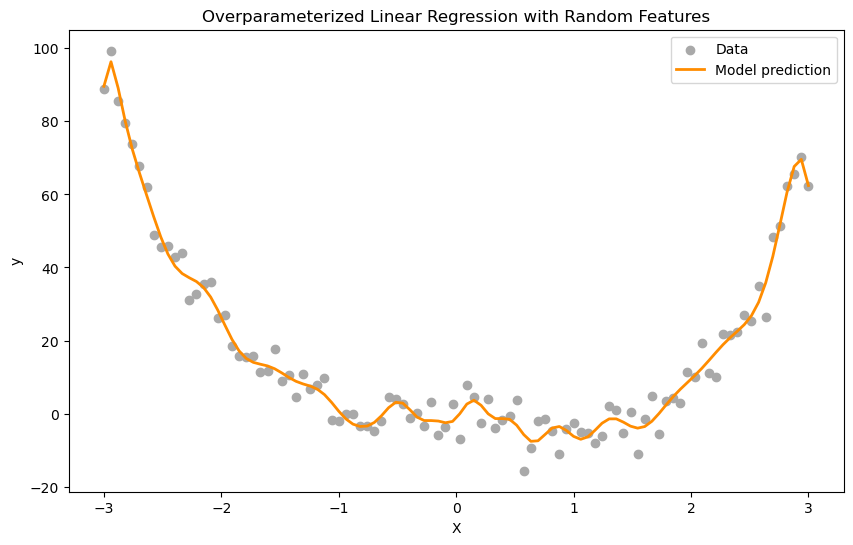

In [19]:
import torch
import matplotlib.pyplot as plt
import numpy as np

import numpy as np
import torch
import matplotlib.pyplot as plt

#Simulate nonlinear data
X = torch.tensor(np.linspace(-3, 3, 100).reshape(-1, 1), dtype=torch.float64)
y = X**4 - 4*X + torch.normal(0, 5, size=X.shape)

#Create and fit RandomFeatures using created method
phi = RandomFeatures(n_features=500)
phi.fit(X)
X_features = phi.transform(X)

#Fit model
model = MyLinearRegression()
optimizer = OverParameterizedLinearRegressionOptimizer(model)
optimizer.fit(X_features, y)

# predict
y_pred = model.predict(X_features).detach()

#Plot predictions vs. true data
plt.figure(figsize=(10, 6))
plt.scatter(X.numpy(), y.numpy(), color='darkgrey', label='Data')
plt.plot(X.numpy(), y_pred.numpy(), color='darkorange', label='Model prediction', linewidth=2)
plt.title("Overparameterized Linear Regression with Random Features")
plt.xlabel("X")
plt.ylabel("y")
plt.legend()
plt.show()



Here, we can see overfitting takes place based on how well the line follows the data. We can assume that these are just quirks/natural variations in the training data, and that the testing data wouldn't be similar. Therefore, the data is overfit.

## Part C: Double Descent In Image Corruption Detection

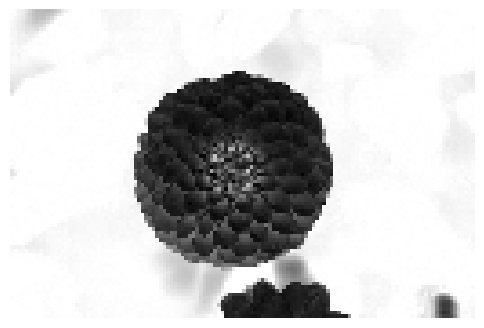

In [20]:
from sklearn.datasets import load_sample_images
from scipy.ndimage import zoom

dataset = load_sample_images()     
X = dataset.images[1]
X = zoom(X,.2) #decimate resolution
X = X.sum(axis = 2)
X = X.max() - X 
X = X / X.max()
flower = torch.tensor(X, dtype = torch.float64) # flower into torch tensor

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(flower, cmap = "gray")
off = ax.axis("off")

In this code chunk, I generate an image of a flower pulled from a sci-kit learn dataset. I then make the image black and white.

In [21]:
def corrupted_image(im, mean_patches = 5):
    '''
    Function used to corrupt the image to create pixelated squares
    '''
    n_pixels = im.size()
    num_pixels_to_corrupt = torch.round(mean_patches*torch.rand(1))
    num_added = 0

    X = im.clone()

    for _ in torch.arange(num_pixels_to_corrupt.item()): 
        
        try: 
        #creates random intervals to place patches
            x = torch.randint(0, n_pixels[0], (2,))

            x = torch.randint(0, n_pixels[0], (1,))
            y = torch.randint(0, n_pixels[1], (1,))

            s = torch.randint(5, 10, (1,))
            
            patch = torch.zeros((s.item(), s.item()), dtype = torch.float64) + 0.5

            # place patch in base image X
            X[x:x+s.item(), y:y+s.item()] = patch
            num_added += 1

            
        except: 
            pass

    return X, num_added

In this code chunk, the function here adds corrupted patches to the image. This is so we can try to fit the image using overfitting in this expirment.

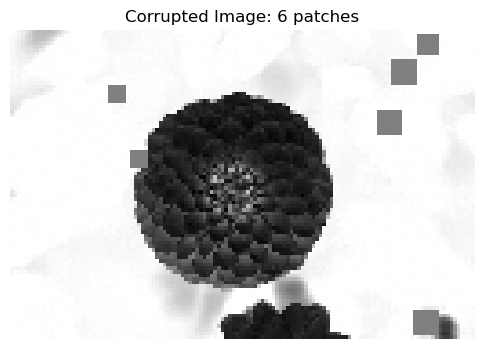

In [22]:
X, y = corrupted_image(flower, mean_patches = 50) # setting x and y to flower image tensor
fig, ax = plt.subplots(1, 1, figsize=(6, 6)) #graphic flower
ax.imshow(X.numpy(), vmin = 0, vmax = 1, cmap= "gray") #making it gray
ax.set(title = f"Corrupted Image: {y} patches") #num of corrupted patches
off = plt.gca().axis("off")

def square(x): 
    #squaring x
    return x ** 2

In this code chunk, I apply the corrupt image function to the original images to put a random number of gray-ed out patches. I also define the square function so I can use it easily in the next step.

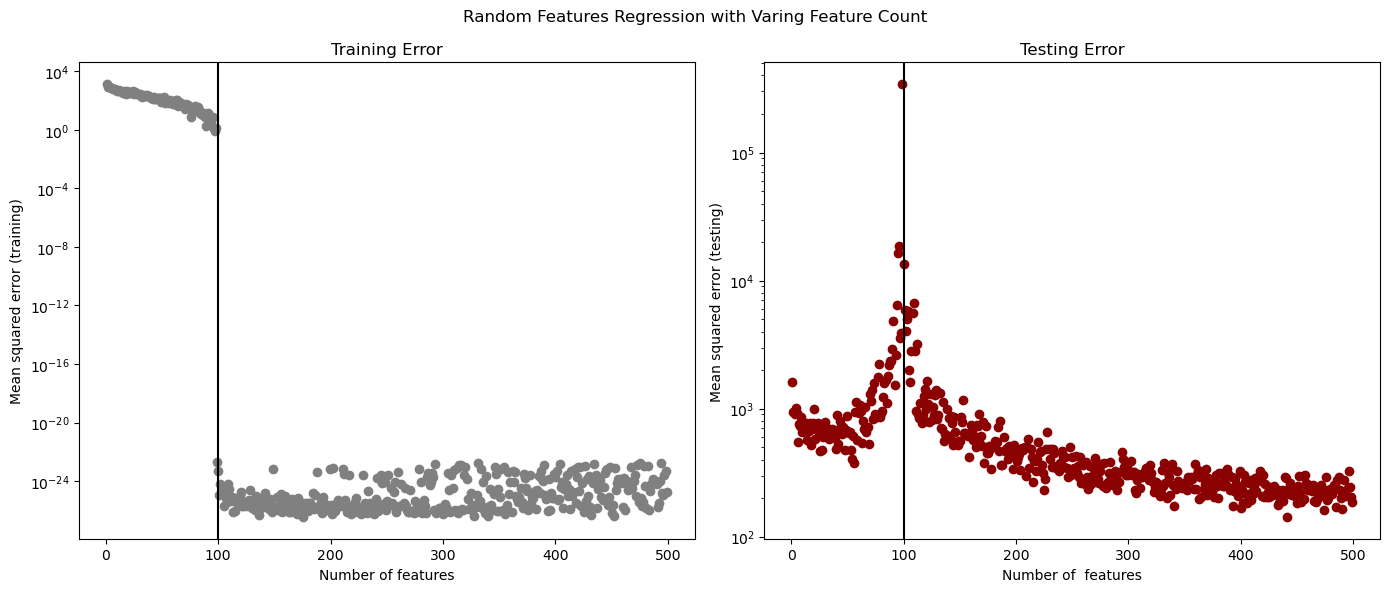

In [23]:
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
n_samples = 200

X = torch.zeros((n_samples, flower.size()[0], flower.size()[1]), dtype = torch.float64) #creating x and y vectors
y = torch.zeros(n_samples, dtype = torch.float64)
for i in range(n_samples): 
    X[i], y[i] = corrupted_image(flower, mean_patches = 100)

X = X.reshape(n_samples, -1)
# X.reshape(n_samples, -1).size()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42) #splitting data

# Initalizing number of features and error counts
feature_sizes = range(1, 500)
train_errors = []
test_errors = []

#interpolation threshold line
interpolation_threshold = X_train.shape[0]

for n_features in feature_sizes:
    #Creating and fit random features
    phi = RandomFeatures(n_features =n_features, activation=  square)
    phi.fit(X_train)

    X_train_phi = phi.transform(X_train)
    X_test_phi = phi.transform(X_test)

    #Fit model
    model = MyLinearRegression()
    optimizer = OverParameterizedLinearRegressionOptimizer(model)
    optimizer.fit(X_train_phi,  y_train)

    #Predict/Compute errors for both datasets
    y_train_pred = model.predict(X_train_phi).detach()
    y_test_pred = model.predict(X_test_phi).detach()

    #Computing MSE of both datasets
    train_mse = mean_squared_error(y_train.numpy(), y_train_pred.numpy())
    test_mse = mean_squared_error(y_test.numpy(), y_test_pred.numpy())

    #adding them to lists t plot
    train_errors.append(train_mse)
    test_errors.append(test_mse)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

#Plot Training Error
ax1.plot(feature_sizes, train_errors, 'o', color='gray')
ax1.set_yscale('log')
ax1.set_xlabel("Number of features")
ax1.set_ylabel("Mean squared error (training)")
ax1.axvline(interpolation_threshold, color='black')
ax1.set_title("Training Error")

#Plot Testing Error
ax2.plot(feature_sizes, test_errors, 'o', color='darkred')
ax2.set_yscale('log')
ax2.set_xlabel("Number of  features")
ax2.set_ylabel("Mean squared error (testing)")
ax2.axvline(interpolation_threshold, color='black')
ax2.set_title("Testing Error")

plt.suptitle("Random Features Regression with Varing Feature Count")
plt.tight_layout()
plt.show()


In this code chunk, I evaluate a linear regression model with a varying number of features. I use a loop to plot the errors generated from the loop so I can figure out how model performance changes as I increase model complexity through the number of features. I then plot the MSE of the training and testing sets.

In [24]:
best_n_features = feature_sizes[np.argmin(test_errors)]
print(f"Best number of features: {best_n_features}")
print("Above threshold" if best_n_features> interpolation_threshold else "Below threshold")

Best number of features: 441
Above threshold


I recieved the smallest error when it was above the interpretation threshold, at 441 features. This means that the model best fit the overparamatized model.

## Part D: Discussion

Through this blog post, I implement additional classes in my logistic regression to analyze overfitting and double descent. Double descent helps us find the sweet spot by adding features and optimizing to identify the ideal number that balances model complexity and generalization. We see this in the graph from Part C, where the test error is minimized at a number of features above the interpolation threshold — indicating better performance in the overparameterized regime.